In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
EGFP = Phasor([0.75,0.25],[0.4,4])

In [3]:
# tdata = np.loadtxt('EGFPt.csv')
# ydata = np.loadtxt('EGFPy2.csv')

In [4]:
# def trim_rescale_data(tdata,ydata,end =int(0.6*380),rescale = True):
#     max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
#     tdata = tdata[:end-max_idx] #start from t = 0
#     ydata = ydata[max_idx:end]  #start from max.
#     if rescale == True:
#         yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
#         ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
#     else:
#         yerr = np.sqrt(ydata)
#     weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
#     return tdata,ydata,weights

In [3]:
def trim_rescale_data(tdata,ydata,r = 10,rescale = True):
    '''Trim and rescale data (if rescale ==True)
       tdata    EGFP.t
       ydata    EGFP.y2 
       r        select points with y>r*max(y)
       rescale  True to rescale, False won't rescale'''
     #select points >r counts only
    ydata = ydata[ydata>r]
    #trim away IRF
    ydata = ydata[np.argmax(ydata):]
    #set tdata to same length, start from t = 0
    tdata = tdata[:len(ydata)]
    if rescale == True:
        yerr = ydata/ydata[0]*np.sqrt(1/ydata+1/ydata[0]) #error after scaling
        ydata = ydata/ydata[0] # scale y data such that the beginning is 1 
    else:
        yerr = np.sqrt(ydata)
    weights = 1/yerr #weighted by 1/yerr, yerr is error after scaling ydata
    return tdata,ydata,weights

def exp(t, A, tau):
    return A * np.exp(-t/tau)

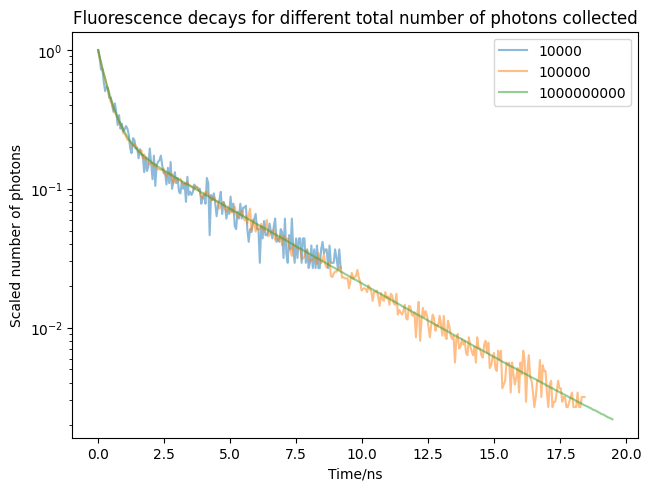

In [4]:
for n_photon in [int(1e4),int(1e5),int(1e9)]:
    EGFP.n_photon = n_photon
    EGFP.multi_exp_data()
    tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2,rescale = True)
    plt.plot(tdata,ydata,alpha = 0.5,label = str(n_photon))
plt.legend()
plt.title('Fluorescence decays for different total number of photons collected' )
plt.xlabel('Time/ns')
plt.ylabel('Scaled number of photons')
plt.yscale('log')

In [5]:
def poisson_deviance_residual(observed, expected):
    '''Return Poisson deviance residual array for given observed data and expected (model) '''
    residual=  np.sign(observed-expected)*np.sqrt(abs(2 *  (observed* np.log(observed/ expected) - (observed- expected)))) #residual array
    return residual

def residual(p, t, data):
    '''Return residual array for lmfit.minimizer to minimize in the sum of squares sense
       Inputs:
       p         lmfit.Parameters() object
       t         time array (independent variable)
       data      data array to be fitted'''
    v = p.valuesdict() #obtain dictionary of parameter values
    expected = 0
    if 'c' in v:
        expected = v['c'] #constant background
    M = 1
    while f'A{M}' in v:
        expected += exp(t, v[f'A{M}'], v[f'tau{M}']) #add exponential component
        M += 1
    return poisson_deviance_residual(data, expected) #lmfit.minimizer minimize the residual array in the sum of squared sense

def initial_params(M,A_guess,tau_guess,c_guess = 0,rescale = True,bg_removed = False):
    '''Create and return initial parameters of fit (lmfit.Parmaeters() object)
       Input:
       M          number of lifetime components
       A_guess    np.array of A1,...AM amplitudes guess
       tau_guess  np.array of tau1,...tauM lifetimes guess
       c_guess    constant background offset guess
       rescale    True if the ydata is rescaled
       bg_removed True if bg is removed
       '''
    p = lmfit.Parameters()
    if bg_removed == False:
        p.add_many(('c', c_guess, True, 0)) #constant background
    for i in range(1,M+1): #for each component
        p.add_many((f'A{i}', A_guess[i-1], True,0)) #amplitude
    for i in range(1,M+1):
        p.add_many((f'tau{i}', tau_guess[i-1], True, 0)) #lifetime
    if rescale == True:
        p[f'A{M}'].set(expr = f'1 {"".join([f"- A{i}" for i in range(1,M)])}') #fix the amplitude of last component
    return p

def chi2(params):
    '''Return chi2 from given parameters (np.array)'''
    M = int((len(params)-1)/2)
    p = initial_params(M,params[1:M+1],params[M+1:],c_guess=params[0],rescale = False)
    return np.dot(residual(p, tdata, ydata),residual(p, tdata, ydata))


### Bi-exp decay fit to EGFP

#### Rescaled data:

In [10]:
EGFP.n_photon = int(1e3)
EGFP.multi_exp_data()
tdata,ydata,weights = trim_rescale_data(EGFP.t,EGFP.y2-EGFP.bg*EGFP.run_time/380)
p1 = initial_params(2,EGFP.amp,EGFP.tau)
p1['c'].set(value = 0, vary = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method='powell')

print(lmfit.fit_report(mi1))


[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 248
    # data points      = 21
    # variables        = 3
    chi-square         = 0.26188805
    reduced chi-square = 0.01454934
    Akaike info crit   = -86.0715724
    Bayesian info crit = -82.9380051
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0 (fixed)
    A1:    0.74571518 +/- 0.03408068 (4.57%) (init = 0.75)
    A2:    0.25428482 +/- 0.00000000 (0.00%) == '1 - A1'
    tau1:  0.26798528 +/- 0.05168815 (19.29%) (init = 0.4)
    tau2:  128.682713 +/-        nan (nan%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau1) = 0.902


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uncertainties/core.py:173: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


### No rescale

Without background:

In [8]:
#generate data for a particular total collected photon number
EGFP.n_photon = int(1e3)
w,p = EGFP.multi_exp_data()

In [9]:
y_no_bg = EGFP.y2-EGFP.bg*EGFP.run_time/EGFP.n_bins
y_with_bg = EGFP.y2
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_no_bg,rescale = False) #bg removed
p1 = initial_params(2,np.max(EGFP.y2)*EGFP.amp,EGFP.tau,rescale = False)
p1['c'].set(value = 0, vary = False)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi2))



[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 422
    # data points      = 19
    # variables        = 4
    chi-square         = 10.8879903
    reduced chi-square = 0.72586602
    Akaike info crit   = -2.57879348
    Bayesian info crit = 1.19896244
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     0 (fixed)
    A1:    25.5984944 (init = 29.25)
    A2:    15.7384402 (init = 9.75)
    tau1:  0.13456927 (init = 0.4)
    tau2:  2.3712e+13 (init = 4)


In [14]:
tdata,ydata,weights = trim_rescale_data(EGFP.t,y_with_bg,rescale = False) #bg removed
p1['c'].set(value = 0, vary = True)
mi2 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi2))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 234
    # data points      = 277
    # variables        = 3
    chi-square         = 267.582800
    reduced chi-square = 0.97657956
    Akaike info crit   = -3.58100236
    Bayesian info crit = 7.29105016
[[Variables]]
    c:     2.34996917 +/- 0.71503383 (30.43%) (init = 0)
    A1:    1887.93376 +/- 9.14335654 (0.48%) (init = 1907)
    tau1:  2.75500937 +/- 0.01403324 (0.51%) (init = 2.43)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, tau1)  = -0.736
    C(A1, tau1) = -0.710
    C(c, A1)    = 0.339


### Mono-exp decay fit to EGFP

In [13]:
p1 = initial_params(1,[np.max(ydata)],EGFP.tau,rescale = False)
mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')
print(lmfit.fit_report(mi1))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 234
    # data points      = 277
    # variables        = 3
    chi-square         = 267.582800
    reduced chi-square = 0.97657956
    Akaike info crit   = -3.58100236
    Bayesian info crit = 7.29105016
[[Variables]]
    c:     2.34996917 +/- 0.71503383 (30.43%) (init = 0)
    A1:    1887.93376 +/- 9.14335654 (0.48%) (init = 1907)
    tau1:  2.75500937 +/- 0.01403324 (0.51%) (init = 2.43)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, tau1)  = -0.736
    C(A1, tau1) = -0.710
    C(c, A1)    = 0.339


### Triple-exp fit

In [15]:

p1 = initial_params(3,[np.max(EGFP.y2*0.49),np.max(EGFP.y2)*0.51,100],EGFP.tau+[10],rescale = False)
mi3 = lmfit.minimize(residual, p1, args=(tdata, ydata),method = 'powell')

print(lmfit.fit_report(mi3))

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 480
    # data points      = 277
    # variables        = 7
    chi-square         = 267.365660
    reduced chi-square = 0.99024319
    Akaike info crit   = 4.19412520
    Bayesian info crit = 29.5622477
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:     1.43713071 +/- 1.53263194 (106.65%) (init = 0)
    A1:    957.263091 +/- 399.959329 (41.78%) (init = 934.43)
    A2:    920.916798 +/- 420.023752 (45.61%) (init = 972.57)
    A3:    15.3096080 +/-        nan (nan%) (init = 100)
    tau1:  2.54684187 +/- 0.23264192 (9.13%) (init = 2.43)
    tau2:  2.98687095 +/- 0.24222312 (8.11%) (init = 3.07)
    tau3:  1.82686752 +/- 0.81294874 (44.50%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau1, tau3) = -1.425
    C(A1, tau3)   = 1.139
    C(tau2, tau3) = 1.101
    C(A1, A2)     = -1.020
    C(c, tau2)    = -0.803
    C(c, tau1)    = 0.728
    C(tau1, tau2) = -0.631

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])


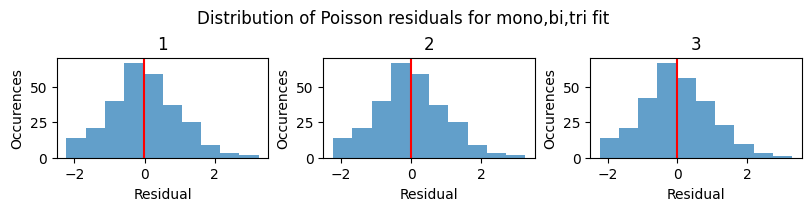

In [16]:
fig,ax = plt.subplots(ncols=3,figsize = (8,2))
fig.suptitle('Distribution of Poisson residuals for mono,bi,tri fit ')
for i in range(3):
    mi = [mi1,mi2,mi3][i]
    resid = residual(mi.params,tdata,ydata)
    ax[i].hist(resid,alpha = 0.7)
    ax[i].axvline(np.mean(residual(mi.params,tdata,ydata)),c='r',label = 'mean')
    ax[i].set_title(range(1,4)[i])
    ax[i].set_xlabel('Residual')
    ax[i].set_ylabel('Occurences')


## Get 100 simulation at each point (bi-exp decay)


In [15]:
def MLEfit(N,tdata,ydata,method ='powell',r=10,rescale=False):

    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, [np.max(ydata * 0.49), np.max(ydata) * 0.51], EGFP.tau, rescale=rescale)
    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)
MLEfit(2,EGFP.t,EGFP.sim_data[2])

,c,A1,A2,tau1,tau2
0,31.050835,0.489624,0.510376,2.420671,3.066687


In [ ]:
def MLEfit(N,tdata,ydata,method ='powell',r=1,rescale=False,bg=True):
    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, np.max(ydata)*EGFP.amp, EGFP.tau, rescale=rescale)
    if bg == False: #background removed
      p1['c'].set(value = 0,vary = False)

    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df(N,method='powell',sim_data=EGFP.sim_data,r=1,rescale=False,bg=True):
  '''Create dataframe of fitted parameters for 100 simulations'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,sim_data[j],method='powell',r=r,rescale=rescale,bg=bg))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

#this would take 10 mins to run
N=2 #components
EGFP.y_list = np.zeros((20,100,380))
EGFP.y_no_bg_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(3,5,20)
df_list = []
for i in range(1):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  EGFP.y_no_bg_list[i] = EGFP.sim_data-EGFP.bg*EGFP.run_time/EGFP.n_bins
  df =val_df(N,sim_data=EGFP.y_list[i])
  df_no_bg = val_df(N,sim_data=EGFP.y_no_bg_list[i],bg=False)
  df_rescale= val_df(N,sim_data=EGFP.y_list[i],rescale = True)
  df_no_bg_rescale= val_df(N,sim_data=EGFP.y_no_bg_list[i],r=1,rescale = True,bg=False)
  df_list.append([df,df_no_bg,df_rescale,df_no_bg_rescale])


In [14]:
df_list

[[           c        A1        A2      tau1      tau2
  0   0.444155  0.698123  0.301877  0.350053  3.966611
  1   0.500246  0.803965  0.196035  0.482162  5.101375
  2   0.535582  0.725442  0.274558  0.373635  3.521841
  3   0.364876  0.792359  0.207641  0.522205  5.121359
  4   0.350461  0.739606  0.260394  0.377153  4.087888
  ..       ...       ...       ...       ...       ...
  95  0.715061  0.725093  0.274907  0.354414  4.138154
  96  0.065472  0.744033  0.255967  0.269705  4.438618
  97  2.253162  0.720937  0.279063  0.224428  1.809357
  98  0.325099  0.780625  0.219375  0.496451  4.895252
  99  1.961779  0.692494  0.307506  0.318626  2.210186
  
  [100 rows x 5 columns],
      c        A1        A2      tau1      tau2
  0   0  0.698534  0.301466  0.367451  4.495551
  1   0  0.801466  0.198534  0.491106  6.002322
  2   0  0.728246  0.271754  0.383618  4.098966
  3   0  0.791684  0.208316  0.527594  5.751037
  4   0  0.740121  0.259879  0.378389  4.441722
  .. ..       ...      

In [ ]:
def MLEfit(N,tdata,ydata,method ='powell',r=10,rescale=False,bg=True):
    tdata, ydata, weights = trim_rescale_data(tdata,ydata, r=r, rescale=rescale)
    p1 = initial_params(N, np.max(ydata)*EGFP.amp, EGFP.tau, rescale=rescale)
    if bg == False: #background removed
      p1['c'].set(value = 0,vary = False)

    mi1 = lmfit.minimize(residual, p1, args=(tdata, ydata), method=method)
    par_dict = {k:[v.value] for k,v in mi1.params.items()} #turn params values into dict
    A_sum = sum([par_dict[f'A{j}'][0] for j in range(1,N+1)]) #sum all An
    for i in range(1,N+1):
      par_dict[f'A{i}'][0]=par_dict[f'A{i}'][0]/A_sum

    return pd.DataFrame.from_dict(par_dict)

def val_df(N,method='powell',sim_data=EGFP.sim_data,r=1,rescale=False,bg=True):
  '''Create dataframe of fitted parameters for 100 simulations'''
  df_list = []
  for j in range(100):
    df_list.append( MLEfit(N,EGFP.t,sim_data[j],method='powell',r=r,rescale=rescale,bg=bg))
    df= pd.concat(df_list).reset_index()
  return df.drop(['index'],axis =1)

#this would take 10 mins to run
N=2 #components
EGFP.y_list = np.zeros((20,100,380))
EGFP.y_no_bg_list = np.zeros((20,100,380))
n_photon_arr = np.logspace(4,9,20)
df_list = []
for i in range(len(n_photon_arr)):
  EGFP.n_photon = n_photon_arr[i]
  EGFP.repeat_sim(100)
  EGFP.y_list[i] = EGFP.sim_data
  EGFP.y_no_bg_list[i] = EGFP.sim_data-EGFP.bg*EGFP.run_time/EGFP.n_bins
  df =val_df(N,sim_data=EGFP.y_list[i])
  df_no_bg = val_df(N,sim_data=EGFP.y_no_bg_list[i],bg=False)
  df_rescale= val_df(N,sim_data=EGFP.y_list[i],rescale = True)
  df_no_bg_rescale= val_df(N,sim_data=EGFP.y_no_bg_list[i],r=30,rescale = True,bg=False)
  df_list.append([df,df_no_bg,df_rescale,df_no_bg_rescale])


In [71]:
# df_list_case = []
# for df in df_list:
#     n_val_df =pd.concat(df,keys = ['bg','no_bg','bg_rescale','no_bg_rescale'],axis = 1) #concat dfs of 4 cases along axis 1
#     df_list_case.append(n_val_df) #append each photon number case
# mle_val_df = pd.concat(df_list_case,keys = range(20))

In [63]:
#mle_val_df = pd.concat(df_list_case,keys = range(20))

In [73]:
#mle_val_df.to_csv('df/mle_val_df.csv')
mle_val_df = pd.read_csv('df/mle_val_df.csv',header=[0, 1], index_col=[0,1]) #read multi-level csv

In [74]:
idx = pd.IndexSlice #extract df using pd.IndexSlice 
#idx[n_photon_row,simulation_row]
#idx[case_col,par_col]
mle_val_df.loc(axis=1)[idx['bg',:]]  #get bg dataframe

bg                                        
                  c        A1        A2      tau1      tau2
0  0       5.123698  0.330167  0.669833  1.680137  2.879109
   1       3.295899  0.456821  0.543179  2.355881  2.859740
   2       1.021172  0.473810  0.526190  2.342063  2.997265
   3       0.043532  0.479243  0.520757  2.432509  3.068891
   4       0.972862  0.420900  0.579100  2.427369  2.982543
...             ...       ...       ...       ...       ...
19 95  10473.729687  0.496764  0.503236  2.427647  3.071422
   96  10601.389700  0.496531  0.503469  2.429669  3.069614
   97  10578.591857  0.496745  0.503255  2.429684  3.069925
   98  10582.901788  0.496795  0.503205  2.429770  3.069707
   99  10585.922184  0.496771  0.503229  2.429702  3.069810

[2000 rows x 5 columns]

In [88]:
new_df = mle_val_df.drop(mle_val_df[mle_val_df.no_bg_rescale.tau2>10].index) #drop rows where tau2 is anamolous
new_df.dropna(inplace = True) #new df without anamolous values
np.unique(new_df.isna())      #check no nan values

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_1061/2871962986.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.85)


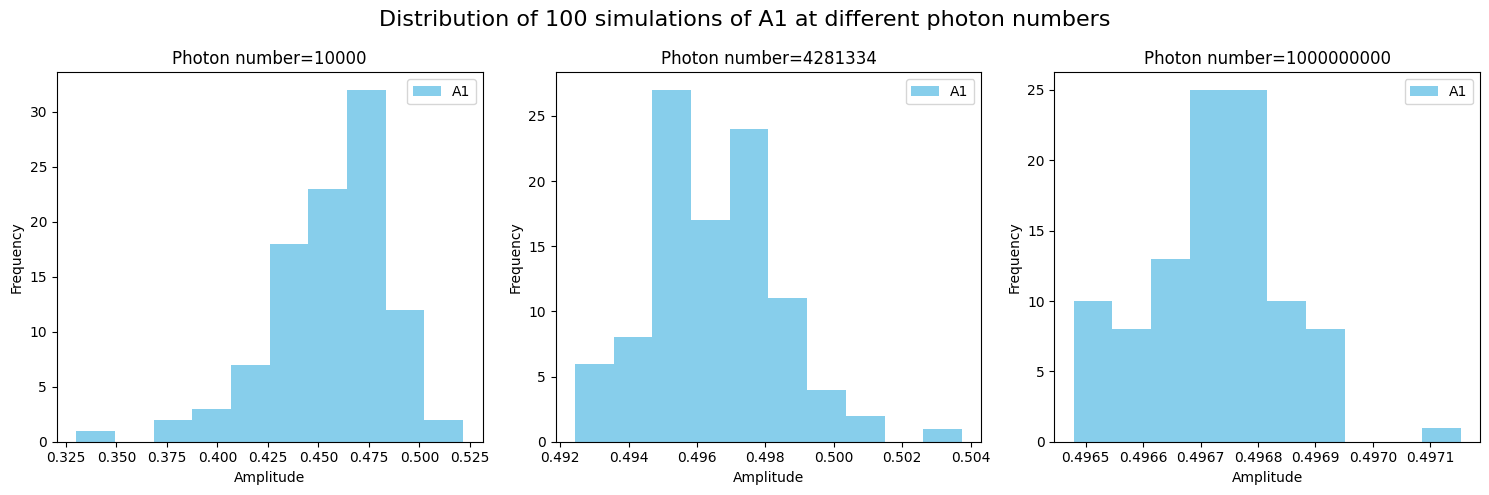

In [91]:
# Setup for loop parameters
indices = [0, 10, 19]  # Indices for low, middle, high photon number
titles = ['Photon number=10000', 'Photon number=4281334', 'Photon number=1000000000']
colors = ['skyblue', 'skyblue', 'skyblue']  # Using the same color, but allows customization
bins = 10  # Assuming you want the same number of bins for each histogram

# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, (index, title) in enumerate(zip(indices, titles)):
    axs[i].hist(mle_val_df.loc[idx[index,:], idx['bg','A1']], bins=bins, color=colors[i])
    axs[i].set_xlabel('Amplitude')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(title)
    axs[i].legend(['A1'])

# Add a main title for the plots
fig.suptitle('Distribution of 100 simulations of A1 at different photon numbers', fontsize=16)

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()


In [92]:
mean_df = new_df.groupby(level=0).mean()
std_df = new_df.groupby(level=0).std()

In [93]:
mean_df

bg                                         no_bg            \
               c        A1        A2      tau1      tau2     c        A1   
0       1.966566  0.463604  0.536396  2.355718  2.949770   0.0  0.491266   
1       1.634331  0.467644  0.532356  2.374261  3.001617   0.0  0.483978   
2       1.378393  0.475128  0.524872  2.403208  3.021440   0.0  0.487473   
3       1.851706  0.481775  0.518225  2.457912  2.996997   0.0  0.492720   
4       2.361904  0.486979  0.513021  2.500536  2.979579   0.0  0.494473   
5       3.385937  0.490125  0.509875  2.483636  3.008308   0.0  0.496344   
6       4.628982  0.494730  0.505270  2.447269  3.049361   0.0  0.497489   
7       7.461046  0.495345  0.504655  2.433590  3.066248   0.0  0.496339   
8      13.422662  0.496263  0.503737  2.430175  3.068275   0.0  0.496617   
9      24.827216  0.496505  0.503495  2.431809  3.068607   0.0  0.496788   
10     45.257641  0.496542  0.503458  2.432734  3.067488   0.0  0.496619   
11     82.759096  0.496742  0.503258  2.429198  3.069932   0.0  0.496868   
12    151.779927  0.496721  0.503279  2.429347  3.070125   0.0  0.496952   
13    279.071822  0.496754  0.503246  2.429536  3.069960   0.0  0.497013   
14    511.703702  0.496629  0.503371  2.430432  3.069206   0.0  0.496903   
15    935.331390  0.496727  0.503273  2.429433  3.070096   0.0  0.496993   
16   1714.941706  0.496744  0.503256  2.429755  3.069883   0.0  0.497005   
17   3145.468574  0.496737  0.503263  2.429851  3.069829   0.0  0.496998   
18   5767.457010  0.496747  0.503253  2.429721  3.069912   0.0  0.497017   
19  10571.615523  0.496726  0.503274  2.429771  3.069823   0.0  0.496989   

                                 bg_rescale                                \
          A2      tau1      tau2          c        A1        A2      tau1   
0   0.508734  2.210661  3.324017   0.002200  0.472401  0.527599  1.596863   
1   0.516022  2.259387  3.218652   0.002187  0.511672  0.488328  1.772680   
2   0.512527  2.319141  3.150311   0.000642  0.612803  0.387197  2.219296   
3   0.507280  2.355268  3.127443   0.000894  0.492477  0.507523  2.139050   
4   0.505527  2.394416  3.096783   0.000733  0.493752  0.506248  2.268719   
5   0.503656  2.408953  3.088224   0.000730  0.486378  0.513622  2.400477   
6   0.502511  2.416174  3.081317   0.000595  0.494454  0.505546  2.438531   
7   0.503661  2.426996  3.073010   0.000531  0.501057  0.498943  2.425199   
8   0.503383  2.431806  3.067474   0.000537  0.498082  0.501918  2.427713   
9   0.503212  2.431285  3.069601   0.000550  0.498246  0.501754  2.428076   
10  0.503381  2.432581  3.067724   0.000546  0.498457  0.501543  2.428519   
11  0.503132  2.429749  3.069606   0.000542  0.501213  0.498787  2.424417   
12  0.503048  2.429459  3.070240   0.000546  0.500194  0.499806  2.425676   
13  0.502987  2.429483  3.070341   0.000548  0.499953  0.500047  2.425774   
14  0.503097  2.430219  3.069736   0.000547  0.499975  0.500025  2.425413   
15  0.503007  2.429692  3.070173   0.000547  0.499934  0.500066  2.425639   
16  0.502995  2.430029  3.069949   0.000548  0.499433  0.500567  2.426344   
17  0.503002  2.430092  3.069950   0.000548  0.499617  0.500383  2.426358   
18  0.502983  2.429874  3.070112   0.000548  0.499638  0.500362  2.426229   
19  0.503011  2.429918  3.070021   0.000548  0.499886  0.500114  2.425915   

             no_bg_rescale                                          
        tau2             c        A1        A2      tau1      tau2  
0   3.487917           0.0  0.652087  0.347913  1.830452  5.524531  
1   3.433030           0.0  0.626387  0.373613  1.949323  4.229979  
2   3.488208           0.0  0.595195  0.404805  2.045093  3.630333  
3   3.164283           0.0  0.557150  0.442850  2.212805  3.320103  
4   3.091313           0.0  0.522228  0.477772  2.303550  3.170080  
5   3.055358           0.0  0.506675  0.493325  2.392189  3.108913  
6   3.069660           0.0  0.504237  0.495763  2.421271  3.090471  
7   3.084352           0.

In [94]:
std_df

bg                                         no_bg            \
            c        A1        A2      tau1      tau2     c        A1   
0    1.179280  0.024102  0.024102  0.114068  0.099477   0.0  0.032277   
1    1.093610  0.023577  0.023577  0.121167  0.092782   0.0  0.027815   
2    0.878122  0.016067  0.016067  0.111405  0.097402   0.0  0.018631   
3    0.791356  0.015880  0.015880  0.127992  0.120256   0.0  0.013216   
4    0.893806  0.014728  0.014728  0.136963  0.128646   0.0  0.008445   
5    0.796130  0.011417  0.011417  0.096636  0.085535   0.0  0.006795   
6    0.779059  0.006904  0.006904  0.049770  0.042320   0.0  0.005674   
7    1.040031  0.004529  0.004529  0.029801  0.026576   0.0  0.004087   
8    1.348673  0.003481  0.003481  0.023593  0.019808   0.0  0.003090   
9    1.682909  0.002249  0.002249  0.015924  0.013582   0.0  0.002163   
10   2.323083  0.001904  0.001904  0.011274  0.009851   0.0  0.001759   
11   3.065975  0.001437  0.001437  0.008820  0.007669   0.0  0.001282   
12   4.598595  0.000942  0.000942  0.006983  0.005936   0.0  0.000847   
13   5.972897  0.000810  0.000810  0.004305  0.003695   0.0  0.000755   
14   9.537874  0.000497  0.000497  0.004283  0.003747   0.0  0.000444   
15  10.722795  0.000380  0.000380  0.002673  0.002307   0.0  0.000352   
16  16.822482  0.000345  0.000345  0.001947  0.001737   0.0  0.000327   
17  17.865256  0.000212  0.000212  0.001242  0.001026   0.0  0.000199   
18  29.998788  0.000137  0.000137  0.001111  0.000896   0.0  0.000135   
19  40.120053  0.000118  0.000118  0.000911  0.000725   0.0  0.000112   

                                 bg_rescale                                \
          A2      tau1      tau2          c        A1        A2      tau1   
0   0.032277  0.206915  0.217439   0.004086  0.220037  0.220037  0.790089   
1   0.027815  0.181331  0.154438   0.003433  0.227779  0.227779  0.832141   
2   0.018631  0.116939  0.093006   0.001269  0.121179  0.121179  0.166089   
3   0.013216  0.075579  0.063258   0.000964  0.156050  0.156050  0.629714   
4   0.008445  0.050872  0.039504   0.000542  0.118583  0.118583  0.536746   
5   0.006795  0.041116  0.029471   0.000357  0.107705  0.107705  0.372641   
6   0.005674  0.030548  0.021972   0.000200  0.060056  0.060056  0.094036   
7   0.004087  0.017387  0.012784   0.000145  0.043436  0.043436  0.067822   
8   0.003090  0.017654  0.012975   0.000101  0.039802  0.039802  0.057231   
9   0.002163  0.010953  0.008212   0.000068  0.020757  0.020757  0.032662   
10  0.001759  0.007983  0.006108   0.000059  0.016607  0.016607  0.027251   
11  0.001282  0.006558  0.004661   0.000037  0.011399  0.011399  0.017186   
12  0.000847  0.004725  0.003572   0.000031  0.008153  0.008153  0.013109   
13  0.000755  0.003294  0.002478   0.000025  0.007106  0.007106  0.011489   
14  0.000444  0.002372  0.001726   0.000018  0.004512  0.004512  0.007968   
15  0.000352  0.001712  0.001267   0.000012  0.003640  0.003640  0.005520   
16  0.000327  0.001425  0.001096   0.000011  0.002901  0.002901  0.004684   
17  0.000199  0.000980  0.000765   0.000007  0.001924  0.001924  0.003119   
18  0.000135  0.000752  0.000506   0.000005  0.001421  0.001421  0.002188   
19  0.000112  0.000561  0.000401   0.000004  0.001120  0.001120  0.001662   

             no_bg_rescale                                          
        tau2             c        A1        A2      tau1      tau2  
0   0.553889           0.0  0.137422  0.137422  0.328272  1.798243  
1   0.571178           0.0  0.166120  0.166120  0.533607  0.986551  
2   0.368589           0.0  0.164227  0.164227  0.570181  0.451825  
3   0.248624           0.0  0.124342  0.124342  0.467774  0.261016  
4   0.167915           0.0  0.101960  0.101960  0.415353  0.159380  
5   0.157194           0.0  0.071419  0.071419  0.236615  0.121758  
6   0.113469           0.0  0.038110  0.038110  0.062562  0.074597  
7   0.083038           0.0  0.028857  0.028857  0.044394  0.050526  
8   0.064297       

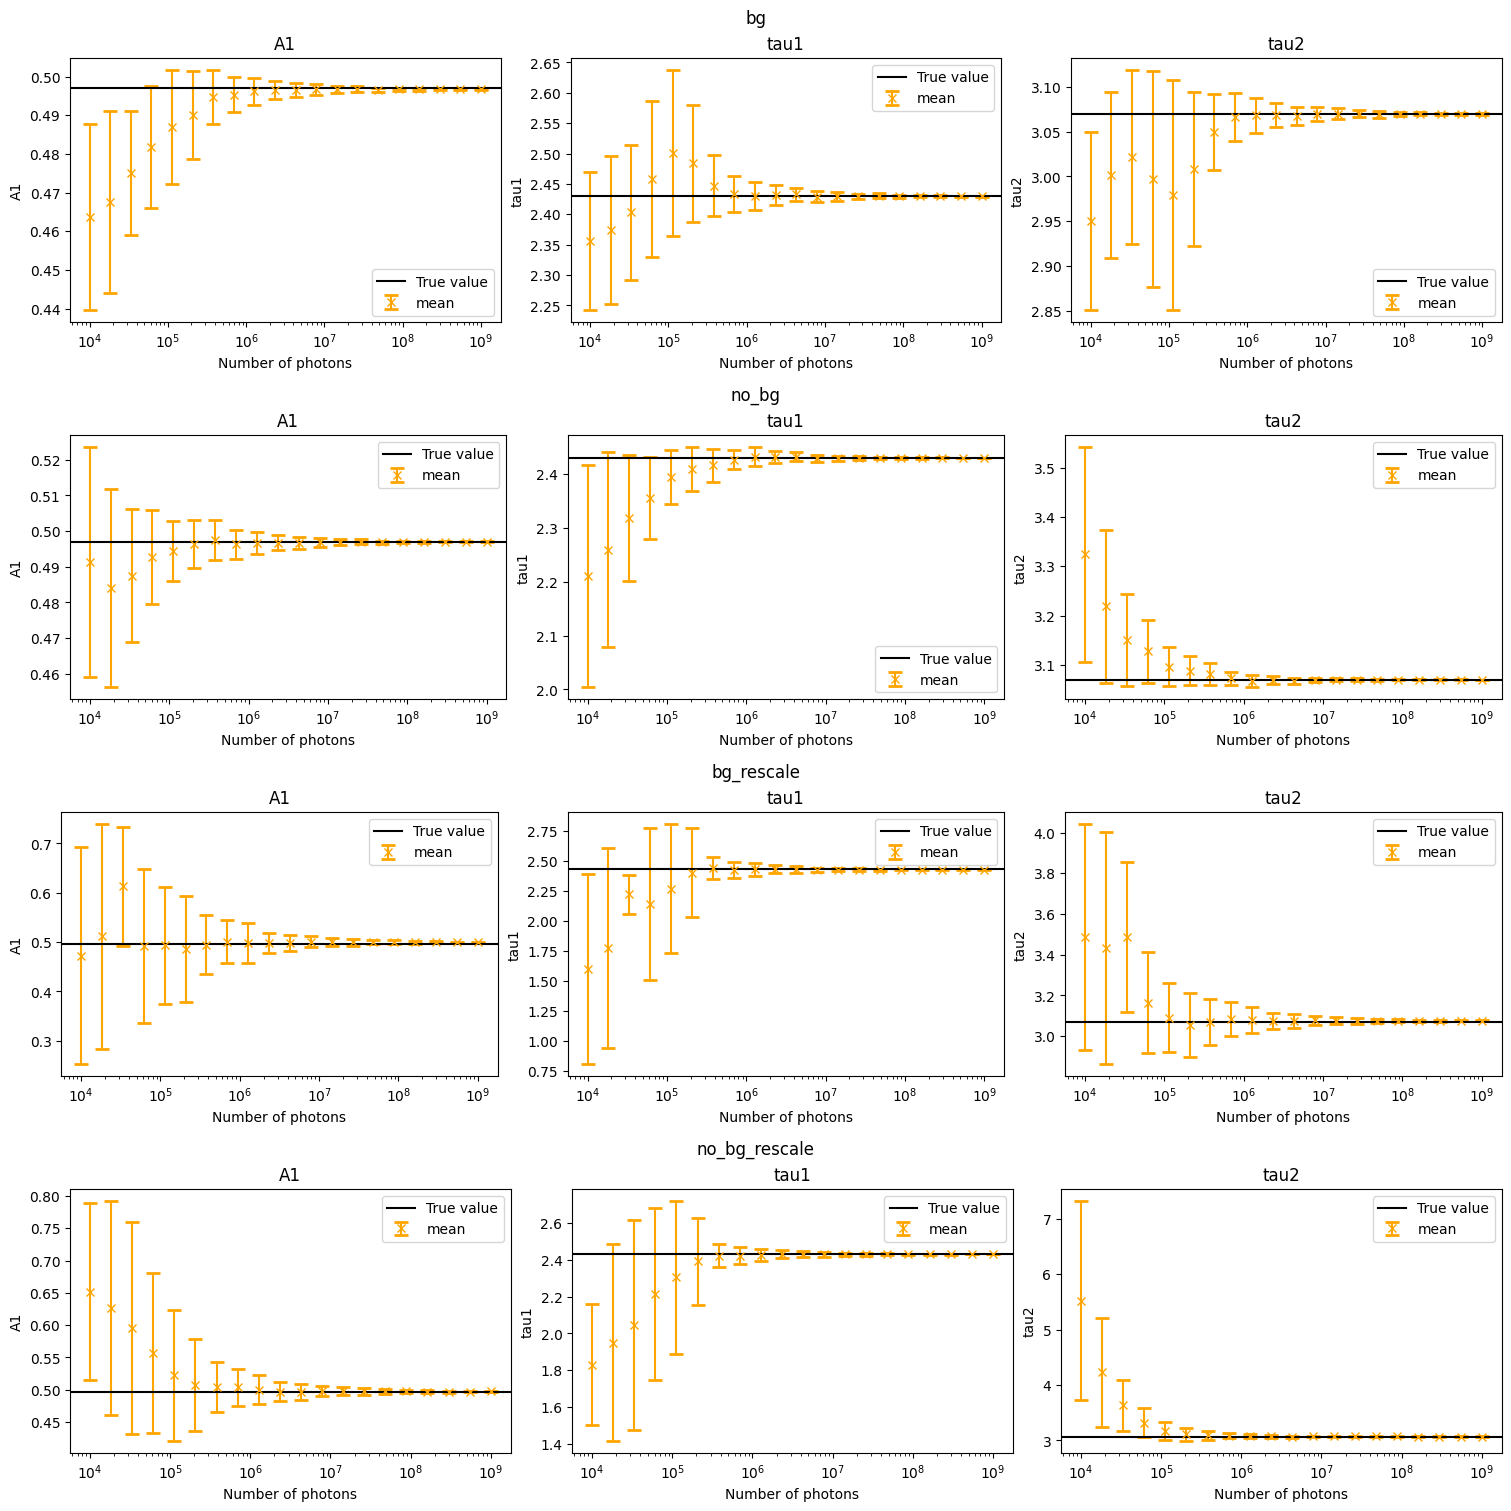

In [95]:
# Set up the subplots
fig = plt.figure( figsize=(15, 15))
big_axs = fig.subfigures(4,1)
true = [0.497,2.43,3.07]

cases = ['bg','no_bg','bg_rescale','no_bg_rescale']
for j in range(4):
    case = cases[j]
    big_axs[j].suptitle(case)
    for i in range(3):
        axs = big_axs[j].add_subplot(1, 3,i+1 )
        col = ['A1','tau1','tau2'][i] #column name
        axs.errorbar(n_photon_arr, mean_df[(case,col)], yerr=std_df[(case,col)], fmt='x', ecolor='orange', capthick=2,
                        capsize=5, color='orange', label='mean')
        axs.axhline(y=true[i], color='k', linestyle='-', label='True value')
        axs.set_xscale('log')
        axs.set_xlabel('Number of photons')
        axs.set_ylabel(col)
        axs.set_title(col)
        axs.legend()


# Show the plot
plt.show()


In [96]:
fig.savefig('fig/mle_cases_deviation.pdf')

In [ ]:
par_dict = {k:v.value for k,v in mi1.params.items()}
A_sum = sum([par_dict[f'A{j}'] for j in range(1,N+1)])
for i in range(1,N+1):
  par_dict[f'A{i}']=par_dict[f'A{i}']/A_sum

In [ ]:
par_dict

{'c': 2.6261220976405935,
 'A1': 0.4119245809129398,
 'A2': 0.5880754190870602,
 'A3': 27.31554596339662,
 'tau1': 2.0589761595478713,
 'tau2': 3.1826795650414406,
 'tau3': 8.088133811301468e-05}

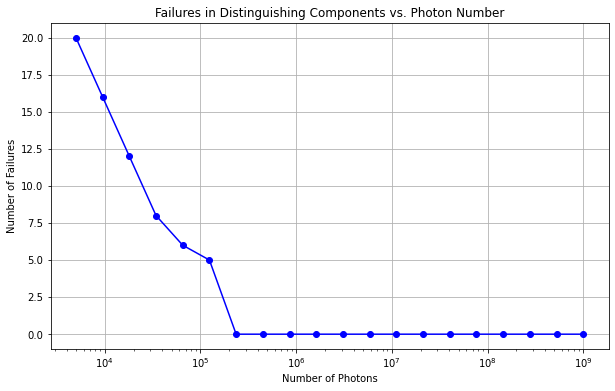

In [ ]:
# Reset failure_counts to ensure clean start
failure_counts = []

# Assuming n_photon_arr is defined and correctly populated
for n_photon in n_photon_arr:
    failures = 0
    for j in range(100):  # For each simulation
        EGFP.n_photon = n_photon
        EGFP.repeat_sim(100)
        # Assuming the simulation data EGFP.sim_data[j] is correctly populated
        # and MLEfit function works as expected
        fit_results_df = MLEfit(2, EGFP.t, EGFP.sim_data[j], method='powell', end=100, rescale=False)
        
        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1
    
    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number')
plt.grid(True)
plt.show()


In [113]:
mle_val_df[np.isclose(mle_val_df.bg.tau1,mle_val_df.bg.tau2,atol= 0.2)]

bg                                         no_bg            \
             c        A1        A2      tau1      tau2     c        A1   
0 46  2.817156  0.500709  0.499291  2.521379  2.547941     0  0.534746   
1 8   0.000156  0.419770  0.580230  2.738365  2.745442     0  0.419270   
  22  1.981756  0.505256  0.494744  2.704104  2.696597     0  0.498527   
  45  2.674530  0.487948  0.512052  2.643588  2.652094     0  0.508835   
  75  1.554953  0.430951  0.569049  2.697596  2.728001     0  0.488273   
...        ...       ...       ...       ...       ...   ...       ...   
5 25  4.106283  0.488699  0.511301  2.749042  2.780018     0  0.488351   
  54  4.602873  0.432437  0.567563  2.678277  2.844440     0  0.476892   
  69  4.795921  0.498229  0.501771  2.725487  2.779213     0  0.498963   
  81  4.406760  0.493028  0.506972  2.679850  2.842088     0  0.490984   
  93  5.786971  0.485515  0.514485  2.664570  2.835694     0  0.493229   

                                   bg_rescale                                \
            A2      tau1      tau2          c        A1        A2      tau1   
0 46  0.465254  2.127225  3.284007   0.013623  0.684149  0.315851  2.391946   
1 8   0.580730  2.739434  2.729379   0.000003  0.779349  0.220651  2.235795   
  22  0.501473  2.446893  3.075613   0.005325  0.283216  0.716784  2.619697   
  45  0.491165  2.414708  3.070619   0.005499  0.830053  0.169947  2.701932   
  75  0.511727  2.433482  3.066985   0.003402  0.563601  0.436399  2.403018   
...        ...       ...       ...        ...       ...       ...       ...   
5 25  0.511649  2.500019  3.017276   0.001030  0.506323  0.493677  2.728873   
  54  0.523108  2.437312  3.072617   0.000065  0.539301  0.460699  2.202439   
  69  0.501037  2.429978  3.067208   0.001178  0.429239  0.570761  2.615974   
  81  0.509016  2.434886  3.068411   0.000758  0.527845  0.472155  2.424910   
  93  0.506771  2.401350  3.100842   0.001120  0.556299  0.443701  2.420002   

               no_bg_rescale                                          
          tau2             c        A1        A2      tau1      tau2  
0 46  2.873277             0  0.569812  0.430188  2.430168  3.069516  
1 8   3.926294             0  0.718410  0.281590  1.951367  4.661357  
  22  2.745604             0  0.438352  0.561648  2.433397  3.067358  
  45  2.785309             0  0.372341  0.627659  2.773381  2.773858  
  75  3.062813             0  0.527594  0.472406  2.427741  3.072872  
...        ...           ...       ...       ...       ...       ...  
5 25  2.807279             0  0.411194  0.588806  2.563122  2.923710  
  54  3.282682             0  0.579837  0.420163  2.281610  3.268113  
  69  2.847245             0  0.444653  0.555347  2.497892  2.966337  
  81  3.077762             0  0.520706  0.479294  2.386512  3.118373  
  93  3.086565             0  0.538841  0.461159  2.362110  3.147495  

[63 rows x 20 columns]

In [119]:
np.where(mle_val_df.bg.A2>0.6)

(array([  0,   8,  12,  41,  43,  56, 123]),)

In [121]:
mle_val_df.iloc[np.where(mle_val_df.bg.A2>0.6)]

bg                                         no_bg            \
             c        A1        A2      tau1      tau2     c        A1   
0 0   5.123698  0.330167  0.669833  1.680137  2.879109     0  0.405813   
  8   3.302134  0.382556  0.617444  2.025396  2.958387     0  0.435056   
  12  1.255085  0.397157  0.602843  2.344688  2.991599     0  0.395065   
  41  1.797098  0.397410  0.602590  2.294858  2.985547     0  0.418416   
  43  2.785577  0.380077  0.619923  2.168848  2.952673     0  0.417193   
  56  0.000000  0.396577  0.603423  2.405713  3.060735     0  0.397357   
1 23  1.579875  0.393671  0.606329  2.323997  3.036219     0  0.417244   

                                      bg_rescale                      \
            A2      tau1      tau2             c        A1        A2   
0 0   0.594187  1.463844  3.588461  1.436911e-05  0.858999  0.141001   
  8   0.564944  1.784694  3.483021  1.871242e-02  0.137636  0.862364   
  12  0.604935  2.394586  3.075908  6.518124e-07  0.294575  0.705425   
  41  0.581584  2.435923  3.087199  1.195415e-04  0.144629  0.855371   
  43  0.582807  1.970147  3.371796  1.493684e-02  0.152535  0.847465   
  56  0.602643  2.395907  3.058375  2.438598e-06  0.180495  0.819505   
1 23  0.582756  2.120979  3.269191  3.547385e-03  0.168897  0.831103   

                         no_bg_rescale                                \
          tau1      tau2             c        A1        A2      tau1   
0 0   1.792344  9.387820             0  0.881036  0.118964  1.664707   
  8   0.022966  2.589736             0  0.905944  0.094056  1.889243   
  12  1.022151  3.031071             0  0.860564  0.139436  1.609991   
  41  0.005639  2.842787             0  0.160961  0.839039  0.454385   
  43  0.005572  2.654409             0  0.889995  0.110005  1.805529   
  56  0.445761  2.816149             0  0.883508  0.116492  1.703881   
1 23  0.076043  2.814667             0  0.166857  0.833143  0.194845   

                    
              tau2  
0 0   1.623016e+10  
  8   4.804423e+10  
  12  7.890796e+10  
  41  2.869197e+00  
  43  1.659000e+11  
  56  7.367807e+11  
1 23  2.852386e+00

In [ ]:
# Reset failure_counts to ensure clean start
failure_counts = []

# Assuming n_photon_arr is defined and correctly populated
for i in range(len(n_photon_arr)):
    failures = 0
    for j in range(100):  # For each simulation

        # Assuming the simulation data EGFP.sim_data[j] is correctly populated
        # and MLEfit function works as expected
        
        # Extract fitted values
        A1 = fit_results_df['A1'].iloc[0]
        A2 = fit_results_df['A2'].iloc[0]
        tau1 = fit_results_df['tau1'].iloc[0]
        tau2 = fit_results_df['tau2'].iloc[0]

        # Failure condition
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            failures += 1
    
    failure_counts.append(failures)

# Plotting the number of failures vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Failures in Distinguishing Components vs. Photon Number')
plt.grid(True)
plt.show()

In [ ]:
# Assuming n_photon_arr is defined and correctly populated
chi2_failure_counts = []

for n_photon in n_photon_arr:
    chi2_failures = 0
    EGFP.n_photon = n_photon
    EGFP.repeat_sim(100)  # Generate simulation data
    for j in range(100):  # For each simulation    
        # Perform the chi-squared fit using the predefined method
        EGFP.fit(exp2, method='leastsq',end = np.where(EGFP.y2<10)[0])
        
        # Extract fitted values directly from EGFP.par
        A1 = EGFP.par['A1'].value
        A2 = EGFP.par['A2'].value
        tau1 = EGFP.par['tau1'].value
        tau2 = EGFP.par['tau2'].value

        # Check for failure conditions similar to the MLE method
        if np.isclose(tau1, tau2, atol=0.2) or A1 > 0.8 or A2 > 0.8:
            chi2_failures += 1

    chi2_failure_counts.append(chi2_failures)

# Plotting the number of failures for the chi-squared fit vs. n_photon
plt.figure(figsize=(10, 6))
plt.plot(n_photon_arr, chi2_failure_counts, marker='o', linestyle='-', color='red', label='Chi-squared Fit Failures')
plt.plot(n_photon_arr, failure_counts, marker='o', linestyle='-', color='blue', label='MLE Fit Failures')
plt.xscale('log')
plt.xlabel('Number of Photons')
plt.ylabel('Number of Failures')
plt.title('Comparison of Failures: MLE vs. Chi-squared Fit')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'n_photon_arr' is not defined